# PhysioNet/Computing in Cardiology Challenge 2020
## Classification of 12-lead ECGs
### Waveform Segmentation Testing

# Setup Notebook

In [27]:
# Import 3rd party libraries
import os
import sys

# Import local Libraries
sys.path.insert(0, os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))))))
from kardioml.visualization.plot_formatted_data import waveform_plot_interact
from kardioml import DATA_PATH

# Configure Notebook
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Plot Waveforms

In [28]:
# Launch interactive plotter
waveform_plot_interact(dataset='physionet_2020_1')

interactive(children=(IntSlider(value=3438, description='filename_id', max=6876), Output()), _dom_classes=('wi…

# Segmentation Dev

In [29]:
import numpy as np
import matplotlib.pylab as plt

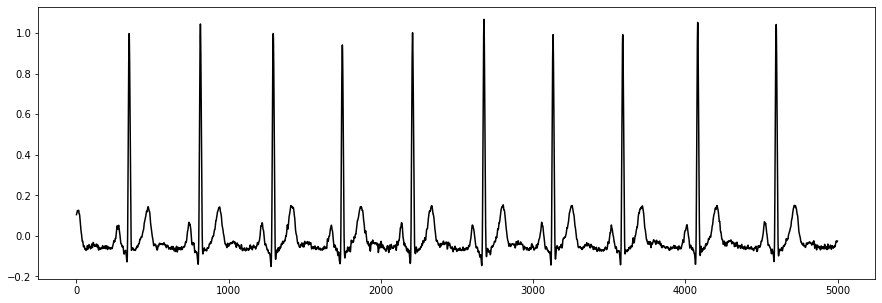

In [30]:
# Get meta data files
filenames = [file.split('.')[0] for file in os.listdir(os.path.join(DATA_PATH, 'physionet_2020_1', 'formatted')) 
             if 'json' in file]

# Import waveforms
signal = np.load(os.path.join(DATA_PATH, 'physionet_2020_1', 'formatted', '{}.npy'.format(filenames[6153])))

fig = plt.figure(figsize=(15, 5), facecolor='w')
plt.plot(signal[:, 0], '-k')
plt.show()

In [39]:
import kardioml.segmentation.teijeiro.inference.searching as searching

TypeError: descriptor '_start' for 'Interval' objects doesn't apply to 'Interval' object

In [31]:
#Searching settings
KFACTOR = 12
MAX_DELAY = 20.0
PRUNE_TIME = 70.0
LONG_RECS = 45000
searching.reasoning.MERGE_STRATEGY = False

NameError: name 'searching' is not defined

In [24]:
# kardioml.segmentation.teijeiro.searching
try:
    cntr = searching.kardioml.segmentation.teijeiro.interp, KFACTOR)
    ltime = (cntr.last_time, t0)
    #Main loop
    while cntr.best is None:
        cntr.step()
        t = time.time()
        if cntr.last_time > ltime[0]:
            ltime = (cntr.last_time, t)
        if (t-ltime[1] > MAX_DELAY or t-t0 > PRUNE_TIME
                or (RECLEN > LONG_RECS
                    and t-t0-sp2ms(cntr.last_time)/1000.0 > 30.0)):
            print('Pruning search')
            cntr.prune()
        if cntr.K > 6 and t-t0 > PRUNE_TIME:
            cntr.K = 6
        if (cntr.K > 3 and RECLEN > LONG_RECS
                and t-t0-sp2ms(cntr.last_time)/1000.0 > 60.0):
            cntr.K = 3
        if cntr.K > 1 and t-t0 > 90.0:
            cntr.K = 1
        if t-t0 > 95.0:
            cntr.best = min(cntr.open) if len(cntr.open) > 0 else min(cntr.closed)
    print('Finished in {0:.3f} seconds'.format(time.time()-t0))
    print('Created {0} interpretations'.format(interp.counter))
    #Best explanation
    be = cntr.best.node
    be.recover_all()
    rstart = next(be.get_observations(o.RhythmStart), None)
    if rstart is not None:
        be.observations.remove(rstart)
except ValueError as err:
    if err.message == 'The root node does not have valid successors':
        be = interp
        print('No interpretations could be created from the base evidence')
    else:
        raise err

NameError: name 'interp' is not defined

# Tools

In [22]:
class kardioml.segmentation.teijeiro.object):
    """
    This class implements the **kardioml.segmentation.teijeiro.* algorithm allowing fine-grained
    control of the steps of the algorithm.
    """
    def __init__(self, root_node, K):
        """
        Initializes a new algorithm execution, receiving as arguments the
        root node for the exploration and the K parameter, which determines the
        exploratory nature of the algorithm.

        Instance Properties
        -------------------
        K:
            Exploration parameter.
        successors:
            Dictionary storing the successor generator of each node.
        last_time:
            Interpretation time of the most advanced interpretation generated
            so far.
        open:
            Sorted list of the open nodes, that can still be expanded.
        closed:
            Sorted list of closed nodes.
        best:
            When a node satisfies the *goal()* function, this attribute is
            assigned to that node. While the finished() method returns False,
            this attribute may be refined with new better interpretations.
        """
        assert K > 0
        self.K = K
        self.root = root_node
        self.successors = weakref.WeakKeyDictionary()
        root_succ = PredictableIter(reasoning.firm_succ(root_node))
        if not root_succ.hasnext():
            raise ValueError('The root node does not have valid successors')
        self.successors[root_node] = root_succ
        self.last_time = root_node.time_point
        ocov, scov, nhyp = valuation(root_node)
        heur = Heuristic(ocov, scov, -self.last_time, nhyp)
        self.open = SortedList([Node(heur, root_node)], key=attrgetter('h'))
        self.closed = SortedList(key=attrgetter('h'))
        self.best = None

    def _update_closed(self, newclosed):
        """
        Updates the *closed* list after an iteration of the algorithm. All
        closed interpretations but the best one are removed from this list.
        """
        if not newclosed:
            return
        tmplst = SortedList(key=attrgetter('h'))
        for lst in (newclosed, self.closed):
            for (ocov, scov, ntime, nhyp), n in lst:
                if -ntime < self.last_time:
                    ocov, scov, nhyp = valuation(n, self.last_time)
                tmplst.add(Node(Heuristic(ocov, scov, ntime, nhyp), n))
        self.closed.clear()
        self.closed.append(tmplst.pop(0))

    def step(self, filt=lambda _: True):
        """
        Performs a new step of the algorithm, by continuing the K-best nodes
        satisfying the *filt* function one step.

        Parameters
        ----------
        filt:
            Boolean function that receives an element of the open list and
            decides if the node can be expanded in this iteration. The first
            K nodes satisfying this filter are expanded.
        """
        newopen = []
        newclosed = []
        ancestors = set()
        optimal = False

        for _ in range(self.K):
            node = next((n for n in self.open if filt(n)
                              and not (optimal and n.node in ancestors)), None)
            #The search stops if no nodes can be expanded or if, being in an
            #optimal context, we need to expand a non-optimal node.
            if node is None or (optimal and node.h.ocov > 0.0):
                break
            self.open.remove(node)
            #Go a step further
            nxt = self.successors[node.node].next()
            self.successors[nxt] = PredictableIter(reasoning.firm_succ(nxt))
            nxtime = nxt.time_point
            if nxtime > self.last_time:
                self.last_time = nxtime
            ocov, scov, nhyp = valuation(nxt, nxtime)
            nxt = Node(Heuristic(ocov, scov, -nxtime, nhyp), nxt)
            #Optimality is determined by the coverage of the successors.
            optimal = optimal or ocov == 0.0
            #Reorganize the open and closed list.
            for n in (node, nxt):
                if self.successors[n.node].hasnext():
                    newopen.append(n)
                    reasoning.save_hierarchy(n.node, ancestors)
                else:
                    newclosed.append(n)
                    if (n is nxt and n.h.ocov == 0.0 and goal(n.node) and
                            (self.best is None or n.h < self.best.h)):
                        self.best = n
        for node in newopen:
            self.open.add(node)
        #The closed list is recalculated by keeping only the best one.
        self._update_closed(newclosed)
        if not self.open:
            if not self.closed:
                raise ValueError('Could not find a complete interpretation.')
            self.best = min(self.closed)

    def prune(self):
        """
        Perform a pruning operation by limiting the size of the *open* list
        only to the K best.
        """
        #Now we get the best nodes with a common valuation.
        newopened = SortedList(key=attrgetter('h'))
        for h, node in self.open:
            ocov, scov, nhyp = valuation(node, self.last_time)
            newopened.add(Node(Heuristic(ocov, scov, h.time, nhyp), node))
        self.open = newopened
        n = min(len(self.open), self.K)
        if not reasoning.SAVE_TREE:
            #We track all interesting nodes in the hierarchy.
            saved = set()
            stop = set()
            for i in range(n):
                node = self.open[i].node
                reasoning.save_hierarchy(node, saved)
                stop.add(node)
                mrg = reasoning._MERGED.get(node)
                if mrg is not None:
                    reasoning.save_hierarchy(mrg, saved)
                    stop.add(mrg)
            for _, node in self.closed:
                reasoning.save_hierarchy(node, saved)
            if self.best is not None:
                reasoning.save_hierarchy(self.best.node, saved)
            #And we prune all nodes outside the saved hierarchy
            stack = [self.root]
            while stack:
                node = stack.pop()
                if node not in saved:
                    node.discard('Sacrificed interpretation')
                elif node not in stop:
                    stack.extend(node.child)
        del self.open[n:]
        #We also clear the reasoning cache, since some interpretations cannot
        #be eligible for merging anymore.
        if self.open:
            earliestime = min(n.past_metrics.time for _, n in self.open)
            reasoning.clear_cache(earliestime)

    def finished(self):
        """
        Checks if the searching procedure is finished, that is, more
        iterations, even if possible, will probably not lead to better
        interpretations that the best one. This is considered true if in the
        open list there are no partial covers with less hypotheses than
        the current best interpretation and that are not ancestors of the
        current best interpretation.
        """
        return (self.best is not None and
                all(self.best.node.is_ancestor(n.node) for n in self.open
                    if n.h.ocov == 0.0 and n.h.nhyp < self.best.h.nhyp))


In [ ]:
class Interpretation(object):
    """
    This class represents the interpretation entity, which is a consistent
    group of abstraction hypotheses combined by the knowledge expressed in
    abstraction patterns. It is the basic entity in our search process, and
    the result of an interpretation process.
    """
    __slots__ = ('name', '_parent', 'child', 'observations', 'unintelligible',
                 'singletons', 'abstracted', 'nabd', 'focus', 'past_metrics',
                 'predinfo', '__weakref__')

    counter = 0

    def __init__(self, parent=None):
        """
        Creates a new empty interpretation, initializing its attributes as a
        shallow copy or a direct assigment of the attributes of the parent. If
        parent is None, the attributes will be empty.

        Instance Properties
        -------------------
        name:
            Unique identificator of the interpretation.
        parent:
            Interpretation from which this one is derived, or None if this is
            a root interpretation.
        child:
            List of interpretations derived from this one.
        past_metrics:
            Summary of old information used for heuristics calculation.
        observations:
            Sortedlist containing all the observations in the interpretation,
            ordered by their start time. NOTE: This property is directly
            assigned from parent interpretation by default.
        singletons:
            Set with all Singleton hypotheses that are present in this
            interpretation. NOTE: This property is directly assigned
            from parent interpretation by default.
        abstracted:
            SortedList containing all the observations that are abstracted by
            some abstraction pattern in this interpretation. NOTE: This
            property is directly assigned from parent interpretation by default
        unintelligible:
            SortedList containing all the observations that cannot be
            abstracted by any abstraction pattern. NOTE: This property is
            directly assigned from parent interpretation by default.
        nabd:
            Number of hypotheses in the interpretation that can be abstracted
            by a higher-level hypothesis. This value is used for the evaluation
            of the interpretation.
        focus:
            Stack containing the focus of attention of the interpretation. Each
            element in this stack is an observation or a non-matched finding
            of a pattern.
        predinfo:
            Dictionary to store predecessor information for consecutive
            observations. Each entry is a 2-tuple (observation, type) with
            the predecessor observation and the type declared by the pattern
            for the consecutivity relation. NOTE: This property is directly
            assigned from parent interpretation by default.
        """
        self.name = str(Interpretation.counter)
        if parent is None:
            self._parent = None
            self.child = []
            self.observations = sortedcontainers.SortedList(key=end_cmp_key)
            self.singletons = set()
            self.abstracted = sortedcontainers.SortedList(key=end_cmp_key)
            self.unintelligible = sortedcontainers.SortedList(key=end_cmp_key)
            self.nabd = 0
            self.past_metrics = PastMetrics(0, 0, 0, 0)
            self.focus = Focus()
            self.predinfo = {}
        else:
            self._parent = weakref.ref(parent, self._on_parent_deleted)
            self.child = []
            self.parent.child.append(self)
            self.observations = parent.observations
            self.singletons = parent.singletons
            self.abstracted = parent.abstracted
            self.unintelligible = parent.unintelligible
            self.nabd = parent.nabd
            self.past_metrics = parent.past_metrics
            self.focus = Focus(parent.focus)
            self.predinfo = parent.predinfo
        Interpretation.counter += 1

    def __str__(self):
        """
        Obtains the representation of the interpretation as a character string.
        """
        return self.name

    def __repr__(self):
        return self.name

    def _on_parent_deleted(self, _):
        """
        Callback function called when the parent interpretation is deleted.
        """
        self._parent = None

    def _get_types(self, obs):
        """
        Obtains a tuple with the types that are used respect to an observation,
        both as hypothesis and as evidence of different patterns.
        """
        types = {type(obs)}.union({p.get_evidence_type(obs)[0]
                                                for p in self.pat_map[obs][1]})
        dmatch = self.get_delayed_finding(obs)
        if dmatch is not None:
            types = types.union({type(dmatch)}, {p.get_evidence_type(dmatch)[0]
                                             for p in self.pat_map[dmatch][1]})
        return tuple(types)

    def _get_proper_obs(self, clazz=Observable, start=0, end=np.inf,
                                         filt=lambda obs: True, reverse=False):
        """
        Obtains a list of observations matching the search criteria, ordered
        by the earliest time of the observation.

        Parameters
        ----------
        clazz:
            Only instances of the *clazz* class (or any subclass) are returned.
        start:
            Only observations whose earlystart attribute is after or equal this
            parameter are returned.
        end:
            Only observations whose lateend attribute is lower or equal this
            parameter are returned.
        filt:
            General filter provided as a boolean function that accepts an
            observation as a parameter. Only the observations satisfying this
            filter are returned.
        reverse:
            Boolean parameter. If True, observations are returned in reversed
            order, from last to first.
        """
        dummy = EventObservable()
        if start == 0:
            idx = 0
        else:
            dummy.time.value = Iv(start, start)
            idx = self.observations.bisect_left(dummy)
        if end == np.inf:
            udx = len(self.observations)
        else:
            dummy.time.value = Iv(end, end)
            udx = self.observations.bisect_right(dummy)
        return (obs for obs in self.observations.islice(idx, udx, reverse)
                if obs.earlystart >= start
                and isinstance(obs, clazz) and filt(obs))

    @property
    def is_firm(self):
        """
        Checks if an interpretation is firm, that is, there are no unmatched
        findings and all the abstraction patterns involved have a sufficient
        set of evidence to support their hypothesis.
        """
        return all(p is None or p.sufficient_evidence
                                                  for p in self.focus.patterns)

    @property
    def time_point(self):
        """
        Obtains the time point of an interpretation, that is, the end time
        value of the last base evidence being considered as evidence of any
        hypothesis in the interpretation. If there are no hypothesis in the
        interpretation, then the time point is just before the first available
        observation.
        """
        lastfocus = max(0, (self.focus.top[0].earlystart - 1 if self.focus
                            else next(self.get_observations()).earlystart - 1))
        return (max(self.abstracted[-1].lateend, lastfocus)
                                             if self.abstracted else lastfocus)

    @property
    def parent(self):
        """
        Obtains the parent of an interpretation.
        """
        return self._parent() if self._parent is not None else None

    @parent.setter
    def parent(self, interpretation):
        """
        Establishes the parent of this interpretation, changing the
        corresponding references in the old and new parents.
        """
        if self._parent is not None and self in self.parent.child:
            self.parent.child.remove(self)
        if interpretation is not None:
            self._parent = weakref.ref(interpretation, self._on_parent_deleted)
            self.parent.child.append(self)
        else:
            self._parent = None

    @property
    def ndescendants(self):
        """Obtains the number of descendants of this interpretation"""
        stack = [self]
        ctr = 0
        while stack:
            ctr += 1
            interp = stack.pop()
            stack.extend(interp.child)
        return ctr

    def is_mergeable(self, other):
        """
        Checks if two interpretations can be merged, that is, they represent
        exactly the same interpretation from the time point in the past_metrics
        structure.
        """
        nobs = len(self.observations)
        nabs = len(self.abstracted)
        nunint = len(self.unintelligible)
        nfocus = len(self.focus)
        return (self is not other
                and len(other.observations) == nobs
                and len(other.abstracted) == nabs
                and len(other.unintelligible) == nunint
                and len(other.focus) == nfocus
                and self.singletons == other.singletons
                and _focus_mergeable(self.focus, other.focus)
                and all(self.unintelligible[i] == other.unintelligible[i]
                        for i in range(nunint-1, -1, -1))
                and all(self.abstracted[i] == other.abstracted[i]
                        for i in range(nabs-1, -1, -1))
                and all(self.observations[i] == other.observations[i]
                        for i in range(nobs-1, -1, -1)))

    def is_ancestor(self, interpretation):
        """
        Checks if a given interpretation is an ancestor in the hierarchy of
        this interpretation. The same interpretation is not considered an
        ancestor.
        """
        if int(self.name) < int(interpretation.name):
            return False
        parent = self.parent
        while True:
            if parent is interpretation:
                return True
            elif parent is None:
                return False
            parent = parent.parent

    def verify_exclusion(self, obs):
        """
        Checks if an observation violates the exclusion relation in this
        interpretation.
        """
        excluded = ap.get_excluded(type(obs))
        other = obsbuf.find_overlapping(obs, excluded)
        verify(other is None,
              'Exclusion relation violation between {0} and {1}', (other, obs))
        dummy = EventObservable()
        dummy.end.value = Iv(obs.latestart, obs.latestart)
        idx = self.observations.bisect_right(dummy)
        while idx < len(self.observations):
            other = self.observations[idx]
            verify(other is obs or not isinstance(other, excluded)
                   or not overlap(other, obs),
                   'Exclusion relation violation between {0} and {1}',
                   (other, obs))
            idx += 1

    def verify_consecutivity_violation(self, obs):
        """
        Checks if an observation violates the consecutivity constraints in this
        interpretation.
        """
        idx = self.observations.bisect_left(obs)
        for obs2 in (o for o in self.observations[idx:] if o in self.predinfo
                                     and isinstance(obs, self.predinfo[o][1])):
            verify(not between(self.predinfo[obs2][0], obs, obs2),
               '{1} violates the consecutivity constraint between {0} and {2}',
               (self.predinfo[obs2][0], obs, obs2))

    def verify_consecutivity_satisfaction(self, obs1, obs2, clazz):
        """
        Checks if a consecutivity constraint defined by two observations is
        violated by some observation in this interpretation or in the
        observations buffer.
        """
        idx = self.observations.bisect_right(obs1)
        dummy = EventObservable()
        dummy.end.value = Iv(obs2.earlyend, obs2.earlyend)
        udx = self.observations.bisect_left(dummy)
        for obs in self.observations.islice(idx, udx):
            verify(obs is obs2 or not isinstance(obs, clazz),
            '{1} violates the consecutivity constraint between {0} and {2}',
            (obs1, obs, obs2))
        hole = Observable()
        hole.start.value = Iv(obs1.lateend, obs1.lateend)
        hole.end.value = Iv(obs2.earlystart, obs2.earlystart)
        other = obsbuf.find_overlapping(hole, clazz)
        verify(other is None,
               '{1} violates the consecutivity constraint between {0} and {2}',
               (obs1, other, obs2))

    def get_observations(self, clazz=Observable, start=0, end=np.inf,
                                         filt=lambda obs: True, reverse=False):
        """
        Obtains a list of observations matching the search criteria, ordered
        by the earliest time of the observation.

        Parameters
        ----------
        clazz:
            Only instances of the *clazz* class (or any subclass) are returned.
        start:
            Only observations whose earlystart attribute is after or equal this
            parameter are returned.
        end:
            Only observations whose lateend attribute is lower or equal this
            parameter are returned.
        filt:
            General filter provided as a boolean function that accepts an
            observation as a parameter. Only the observations satisfying this
            filter are returned.
        reverse:
            Boolean parameter. If True, observations are returned in reversed
            order, from last to first.
        """
        #We perform a combination of the observations from the global buffer
        #and from the interpretation.
        geng = obsbuf.get_observations(clazz, start, end, filt, reverse)
        genl = self._get_proper_obs(clazz, start, end, filt, reverse)
        dummy = EventObservable()
        dummy.start.value = Iv(np.inf, np.inf)
        nxtg = next(geng, dummy)
        nxtl = next(genl, dummy)
        while True:
            nxt = min(nxtg, nxtl)
            if nxt is dummy:
                return
            elif nxt is nxtg:
                nxtg = next(geng, dummy)
            else:
                nxtl = next(genl, dummy)
            yield nxt

    def remove_old(self, time=None):
        """Removes old observations from the interpretation."""
        if time is None:
            time = max(self.past_metrics.time,
                       self.focus.earliest_time) - C.FORGET_TIMESPAN
        #A minimum number of observations is kept
        nmin = min(C.MIN_NOBS, len(self.observations))
        if nmin > 0:
            time = max(self.past_metrics.time,
                       min(time, self.observations[-nmin].lateend-1))
        dummy = EventObservable()
        dummy.end.value = Iv(time, time)
        nhyp = abst = abstime = 0.0
        #Old observations are removed from all lists.
        for lstname in ('observations', 'abstracted', 'unintelligible'):
            lst = getattr(self, lstname)
            idx = lst.bisect_right(dummy)
            if (idx > 0 and self.parent is not None
                    and getattr(self.parent, lstname) is lst):
                lst = lst.copy()
                setattr(self, lstname, lst)
            if lstname == 'observations':
                nhyp = idx
            elif lstname == 'abstracted':
                abstime = sum(o.earlyend - o.latestart + 1 for o in lst[:idx]
                              if ap.get_obs_level(type(o)) == 0)
                abst = idx
            del lst[:idx]
        self.past_metrics = PastMetrics(time, self.past_metrics.abst+abst,
                                        self.past_metrics.abstime+abstime,
                                        self.past_metrics.nhyp + nhyp)

    def recover_all(self):
        """
        Recovers all observations from the ancestor interpretations,
        in order to have the full interpretation from the beginning of the
        process. Hypotheses in the focus of attention are also included in the
        *observations* attribute.
        """
        allobs = set(self.observations)
        interp = self.parent
        while interp is not None:
            allobs |= set(interp.observations)
            interp = interp.parent
        allobs.update((o for o, p in self.focus._lst if p is not None
                                                        and o is p.hypothesis))
        allobs = sortedcontainers.SortedList(allobs)
        #Duplicate removal (set only prevents same references, not equality)
        i = 0
        while i < len(allobs)-1:
            obs = allobs[i]
            while allobs[i+1] == obs:
                allobs.pop(i+1)
                if i == len(allobs)-1:
                    break
            i += 1
        self.observations = sortedcontainers.SortedList(allobs)

    def detach(self, reason=''):
        """
        Detachs this interpretation from the interpretations tree, being from
        that moment a new root.
        """
        #Uncomment to debug.
        #print str(self), reason
        if self.parent is not None:
            parent = self.parent
            parent.child.remove(self)
            self.parent = None

    def discard(self, reason=''):
        """
        Discards this interpretation, and recursively all the descendant
        interpretations.
        """
        self.detach(reason)
        stack = self.child[:]
        while stack:
            interp = stack.pop()
            interp.detach('Parent interpretation discarded')
            stack.extend(interp.child)

    def get_child(self, name):
        """
        Obtains the child interpretation of this one with the given id.
        """
        name = str(name)
        queue = deque([self])
        while queue:
            head = queue.popleft()
            if head.name == name:
                return head
            for subbr in head.child:
                queue.append(subbr)
        raise ValueError('No child interpretation with such name')

In [40]:
import cmath

In [50]:
import cmath
import numpy as np

A=0.5474576271186441
C1=2
C2=0
F=-3.552713678800501e-15j
R=(-0.015625+0j)
T=1.0981999999999998
Z=(-2.381980756934888-23.443987532304696j)

F = R - T*Z - C1*np.sqrt(A**2*Z**2-1) - C2*np.sqrt(Z**2-1)
print(F)
print(type(F))

0j
<class 'numpy.complex128'>


In [51]:
import cmath
import numpy as np

A=0.5474576271186441
C1=2
C2=0
F=-3.552713678800501e-15j
R=(-0.015625+0j)
T=1.0981999999999998
Z=(-2.381980756934888-23.443987532304696j)

F = R - T*Z - C1*cmath.sqrt(A**2*Z**2-1) - C2*cmath.sqrt(Z**2-1)
print(F)
print(type(F))

0j
<class 'complex'>


In [54]:
Z**2

(-543.94671908845+111.68625433554244j)

In [55]:
np.power(Z, 2)

(-543.94671908845+111.68625433554244j)